[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel-analytics/BigDL/blob/main/python/chronos/colab-notebook/howto/how_to_export_onnx_files.ipynb)

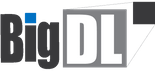

# Export the ONNX model files to disk

## Introduction

When a forecaster is accelerated by ONNXRuntime, we can save the ONNX model files to disk by calling `export_onnx_file`. In this guidance, **we demonstrate how to export the ONNX model files to disk** in detail.

We will take `TCNForecaster` and nyc_taxi dataset as an example in this guide.

## Setup

Before we begin, we need to install Chronos if it isn’t already available, we choose to use pytorch as deep learning backend.

In [ ]:
!pip install --pre --upgrade bigdl-chronos[pytorch]
# install ONNXRuntime
!pip install onnx
!pip install onnxruntime
# uninstall torchtext to avoid version conflict
!pip uninstall -y torchtext
# for quantization
!pip install neural-compressor
!pip install onnxruntime-extensions

> 📝**Note**
> 
> - Although Chronos supports inferencing on a cluster, the method to export model files can only be used when forecaster is a non-distributed version.
> - Only pytorch backend deep learning forecasters support onnxruntime acceleration.

## Forecaster preparation

Before the exporting process, a forecaster should be created and trained. The training process is introduced in the previous guidance [Train forcaster on single node](https://bigdl.readthedocs.io/en/latest/doc/Chronos/Howto/how_to_train_forecaster_on_one_node.html) in detail, therefore we directly create and train a `TCNForecaster` based on the nyc taxi dataset.

In [ ]:
# data preparation
def get_data():
    from bigdl.chronos.data import get_public_dataset
    from sklearn.preprocessing import StandardScaler

    # load the nyc taxi datset
    tsdata_train, tsdata_val, tsdata_test = get_public_dataset(name='nyc_taxi')

    stand = StandardScaler()
    for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
        tsdata.impute()\
              .scale(stand, fit=tsdata is tsdata_train)
    
    # convert `tsdata_train`, `tsdata_test` and `tsdata_val` to pytorch dataloader
    train_data = tsdata_train.to_torch_data_loader(roll=True, lookback=48, horizon=1)
    test_data = tsdata_test.to_torch_data_loader(roll=True, lookback=48, horizon=1)
    val_data = tsdata_val.to_torch_data_loader(roll=True, lookback=48, horizon=1)

    return train_data, test_data, val_data

# trained forecaster preparation
def get_trained_forecaster(train_data):
    from bigdl.chronos.forecaster import TCNForecaster
    # create a TCNForecaster
    forecaster = TCNForecaster(past_seq_len=48,
                               future_seq_len=1,
                               input_feature_num=1,
                               output_feature_num=1)
    
    # train the forecaster on the taining data
    forecaster.fit(train_data)
    return forecaster


## Export the ONNX model files

When a trained forecaster is ready and forecaster is a non-distributed version, we provide with `export_onnx_file` method to export the ONNX model files to disk. The `export_onnx_file` method has 2 parameters: `dirname` is the location to save the ONNX files, and `quantized_dirname` is the location to save the quantized ONNX files when you have a quantized forecaster.

In [ ]:
from pathlib import Path

# get data for training and testing and validating
train_data, test_data, val_data = get_data()
# get a trained forecaster
forecaster = get_trained_forecaster(train_data)

# quantize the forecaster
forecaster.quantize(train_data, val_data=val_data,
                    framework='onnxrt_qlinearops')

# create a directory to save onnx files
dirname = Path("onnx_files")
dirname.mkdir(exist_ok=True)
ckpt_name = dirname / "fp32_onnx"
ckpt_name_q = dirname / "int_onnx"

# export the onnx files
forecaster.export_onnx_file(dirname=ckpt_name, quantized_dirname=ckpt_name_q)


> 📝**Note**
> 
> - When `export_onnx_file` is called, the forecaster will automatically build an ONNXRuntime session with default settings. So you can directly call this method without calling `predict_with_onnx` first. But when you want to export quantized onnx model files, you should quantize the forecaster by calling `quantize` method first.
> - If you just need to export fp32 onnx files, you could specify `dirname` only and set `quantized_dirname` to `None`:
> `forecaster.export_openvino_file(dirname=ckpt_name, quantized_dirname=None)`

The files exported will be saved at `onnx_files` directory. 

There are 2 files in each subdirectory:

- `nano_model_meta.yml`: meta information of the saved model checkpoint
- `onnx_saved_model.onnx`: model checkpoint for general use, describes model structure

You only need to take `onnx_saved_model.onnx` for futher usage.